# 词的相似性和类比任务
在 14.4节中，我们在⼀个⼩的数据集上训练了⼀个word2vec模型，并使⽤它为⼀个输⼊词寻找语义相似的
词。实际上，在⼤型语料库上预先训练的词向量可以应⽤于下游的⾃然语⾔处理任务，这将在后⾯的 15节中
讨论。为了直观地演⽰⼤型语料库中预训练词向量的语义，让我们将预训练词向量应⽤到词的相似性和类⽐
任务中。

In [1]:
import os
import torch
from torch import nn
from d2l import torch as d2l

## 加载预训练词向量
以下列出维度为50、100和300的预训练GloVe嵌⼊，可从GloVe⽹站下载。预训练的fastText嵌⼊有多种语
⾔。这⾥我们使⽤可以从fastText⽹站下载300维度的英⽂版本（“wiki.en”）。

In [2]:
#@save
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip',
                                '0b8703943ccdb6eb788e6f091b8946e82231bc4d')
#@save
d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip',
                                 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')
#@save
d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip',
                                  'b5116e234e9eb9076672cfeabf5469f3eec904fa')
#@save
d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip',
                           'c1816da3821ae9f43899be655002f6c723e91b88')

加载这些预训练的GloVe和fastText嵌⼊，我们定义了以下TokenEmbedding类

In [3]:
#@save
class TokenEmbedding:
    """GloVe嵌⼊"""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}
    
    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe⽹站：https://nlp.stanford.edu/projects/glove/
        # fastText⽹站：https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # 跳过标题信息，例如fastText中的⾸⾏
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)
    
    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                    for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

下⾯我们加载50维GloVe嵌⼊（在维基百科的⼦集上预训练）。创建TokenEmbedding实例时，如果尚未下载指
定的嵌⼊⽂件，则必须下载该⽂件。

In [4]:
glove_6b50d = TokenEmbedding('glove.6b.50d')

输出词表⼤⼩。词表包含400000个词（词元）和⼀个特殊的未知词元。

In [5]:
len(glove_6b50d)

400001

可以得到词表中⼀个单词的索引，反之亦然。

In [6]:
glove_6b50d.token_to_idx['beautiful'], glove_6b50d.idx_to_token[3367]

(3367, 'beautiful')

## 应用预训练词向量
使⽤加载的GloVe向量，我们将通过下⾯的词相似性和类⽐任务中来展⽰词向量的语义。

### 词相似度
根据词向量之间的余弦相似性为输⼊词查找语义相似的词，我们实现了以下knn（k近
邻）函数。

In [7]:
def knn(W, x, k):
    # 增加1e-9以获得数值稳定性
    cos = torch.mv(W, x.reshape(-1,)) / (
        torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) *
        torch.sqrt((x * x).sum()))
    _, topk = torch.topk(cos, k=k)
    return topk, [cos[int(i)] for i in topk]

然后，使⽤TokenEmbedding的实例embed中预训练好的词向量来搜索相似的词。

In [9]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn2(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]): # 排除输⼊词
        print(f'{embed.idx_to_token[int(i)]}：cosine相似度={float(c):.3f}')

glove_6b50d中预训练词向量的词表包含400000个词和⼀个特殊的未知词元。排除输⼊词和未知词元后，我
们在词表中找到与“chip”⼀词语义最相似的三个词。

In [18]:
get_similar_tokens('chip', 3, glove_6b50d)

chips：cosine相似度=0.928
intel：cosine相似度=0.875
electronics：cosine相似度=0.874


下⾯输出与“baby”和“beautiful”相似的词。

In [11]:
get_similar_tokens('baby', 3, glove_6b50d)

babies：cosine相似度=0.919
boy：cosine相似度=0.900
girl：cosine相似度=0.896


In [12]:
get_similar_tokens('beautiful', 3, glove_6b50d)

lovely：cosine相似度=0.961
gorgeous：cosine相似度=0.947
wonderful：cosine相似度=0.915


### 词类比
除了找到相似的词，我们还可以将词向量应⽤到词类⽐任务中。例如，“man”:“woman”::“son”:“daughter”
是⼀个词的类⽐。“man”是对“woman”的类⽐，“son”是对“daughter”的类⽐。具体来说，词类⽐任务
可以定义为：对于单词类⽐a : b :: c : d，给出前三个词a、b和c，找到d。⽤vec(w)表⽰词w的向量，为了完成
这个类⽐，我们将找到⼀个词，其向量与vec(c) + vec(b) − vec(a)的结果最相似。

In [13]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])] # 删除未知词

让我们使⽤加载的词向量来验证“male-female”类⽐。

In [14]:
get_analogy('man', 'woman', 'son', glove_6b50d)

'daughter'

下⾯完成⼀个“⾸都-国家”的类⽐：“beijing”: “china”:: “tokyo”: “japan”。这说明了预训练词向量中的语义。

In [15]:
get_analogy('beijing', 'china', 'tokyo', glove_6b50d)

'japan'

另外，对于“bad”: “worst”:: “big”: “biggest”等“形容词-形容词最⾼级”的⽐喻，预训练词向量可
以捕捉到句法信息。

In [16]:
get_analogy('bad', 'worst', 'big', glove_6b50d)

'biggest'

为了演⽰在预训练词向量中捕捉到的过去式概念，我们可以使⽤“现在式-过去式”的类⽐来测试句法：“do”
: “did”:: “go”: “went”。

In [17]:
get_analogy('do', 'did', 'go', glove_6b50d)

'went'

## 小结
* 在实践中，在⼤型语料库上预先练的词向量可以应⽤于下游的⾃然语⾔处理任务。
* 预训练的词向量可以应⽤于词的相似性和类⽐任务。

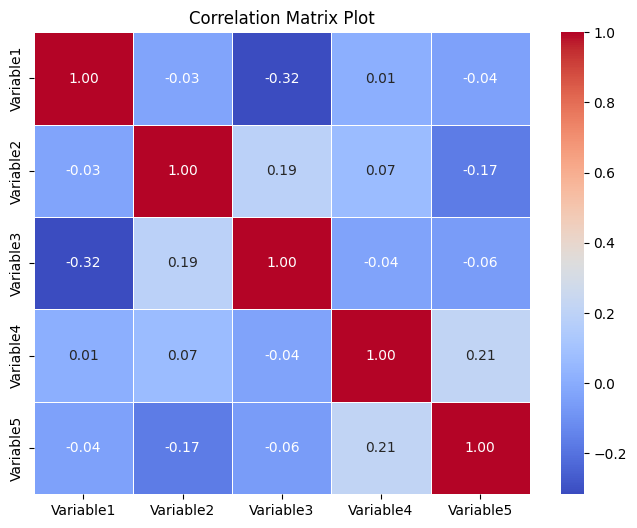

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 生成一些示例数据
np.random.seed(42)
data = np.random.rand(64, 5)  # 10个样本，每个样本包含5个变量

# 将数据转换为DataFrame
df = pd.DataFrame(data, columns=['Variable1', 'Variable2', 'Variable3', 'Variable4', 'Variable5'])

# 计算变量之间的相关系数矩阵
correlation_matrix = df.corr()

# 使用seaborn绘制相关矩阵图
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Plot')
plt.show()
